In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from scipy.interpolate import griddata
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

In [2]:
home_folder = '/storage/shared/oceanparcels/input_data/NEMO16_CMCC/'
# we need to coordinates file to access the corner points - glamf/gphif
model_mask_file = home_folder + 'GLOB16L98_mesh_mask_atlantic.nc'

mask_ds = xr.open_dataset(model_mask_file, decode_times=False).load()
mask_lon = mask_ds['glamf'].values
mask_lat = mask_ds['gphif'].values
mask_land = mask_ds['tmask'].values

# additionaly load the following fields to 
lats_new=mask_ds['nav_lat'].values
lons_new=mask_ds['nav_lon'].values


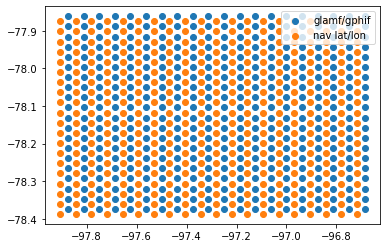

In [3]:
x=mask_ds['glamf']
y=mask_ds['gphif']

# get the mask values of the corner points
c=mask_ds['tmask'][:]
fig=plt.figure()
ax=plt.axes()

ax.scatter(x[0,:20,:20],y[0,:20,:20],label='glamf/gphif')
ax.scatter(mask_ds['nav_lon'][:20,:20],mask_ds['nav_lat'][:20,:20], label='nav lat/lon')
ax.legend()

<h4> Given a delta value- resolution of particles to be relased across a regular grid, compute the lats and lons of release points. \n Benguela Upwelling region lies between 10E-20E and 35S-20S ().

In [4]:
# Only upwelling region: (961, 641), 0.0625/4: #n: 370831
left_lon = 10.0
right_lon = 20.0
top_lat = -15
bottom_lat = -35

# extra region- FTLE: (1601, 1025), 0.0625/4 #n 1m
# left_lon = 10
# right_lon = 20
# top_lat = -15
# bottom_lat = -35

# Test region : near Cape Cauldron
# left_lon = 17.5
# right_lon = 19
# top_lat = -32.5
# bottom_lat = -34.5

den=32
delta= 1/den

lons = np.arange(left_lon, right_lon + delta, delta)
lats = np.arange(bottom_lat, top_lat + delta, delta)
regions_lons, regions_lats = np.meshgrid(lons, lats)
print(regions_lons.shape)
print(delta)

(641, 321)
0.03125


In [5]:
points = list(zip(regions_lons.flatten(), regions_lats.flatten()))
release_lons, release_lats = zip(*points)
print(len(release_lons))

205761


<h4>griddata function doesnt work well for curvilinear data - hence the masking related issues.

In [6]:
land_val_release = griddata((lons_new.ravel(), lats_new.ravel()), mask_land[0,0,:,:].ravel(),
                            (regions_lons, regions_lats), method='nearest', fill_value=0)     # Method 1- improved masking with nav_lat and nav_lon

bool_mask = land_val_release.astype(bool)
ocean_lons = regions_lons[bool_mask]
ocean_lats = regions_lats[bool_mask]
len(ocean_lats)

104640

In [7]:
# np.savez_compressed('/nethome/manra003/analysis/dispersion/Benguela_cropped_boolmask_961X641.npz', mask=bool_mask, lons=regions_lons, lats=regions_lats)

# np.savez_compressed('/nethome/manra003/analysis/dispersion/Benguela_cropped_boolmask_1601x1025.npz', mask=bool_mask, lons=regions_lons, lats=regions_lats)

In [8]:
locations = pd.DataFrame(data=[ocean_lons, ocean_lats]).T
locations.columns=['Longitude', 'Latitude']
locations.to_csv('/nethome/manra003/atlanteco_plankton_plastic_nutrients_dispersion/data/Benguela_release_points_1ov{0}_{1}x{2}grid.csv'.format(den, regions_lons.shape[0], regions_lons.shape[1]),
        index=False, header=True, sep=',')

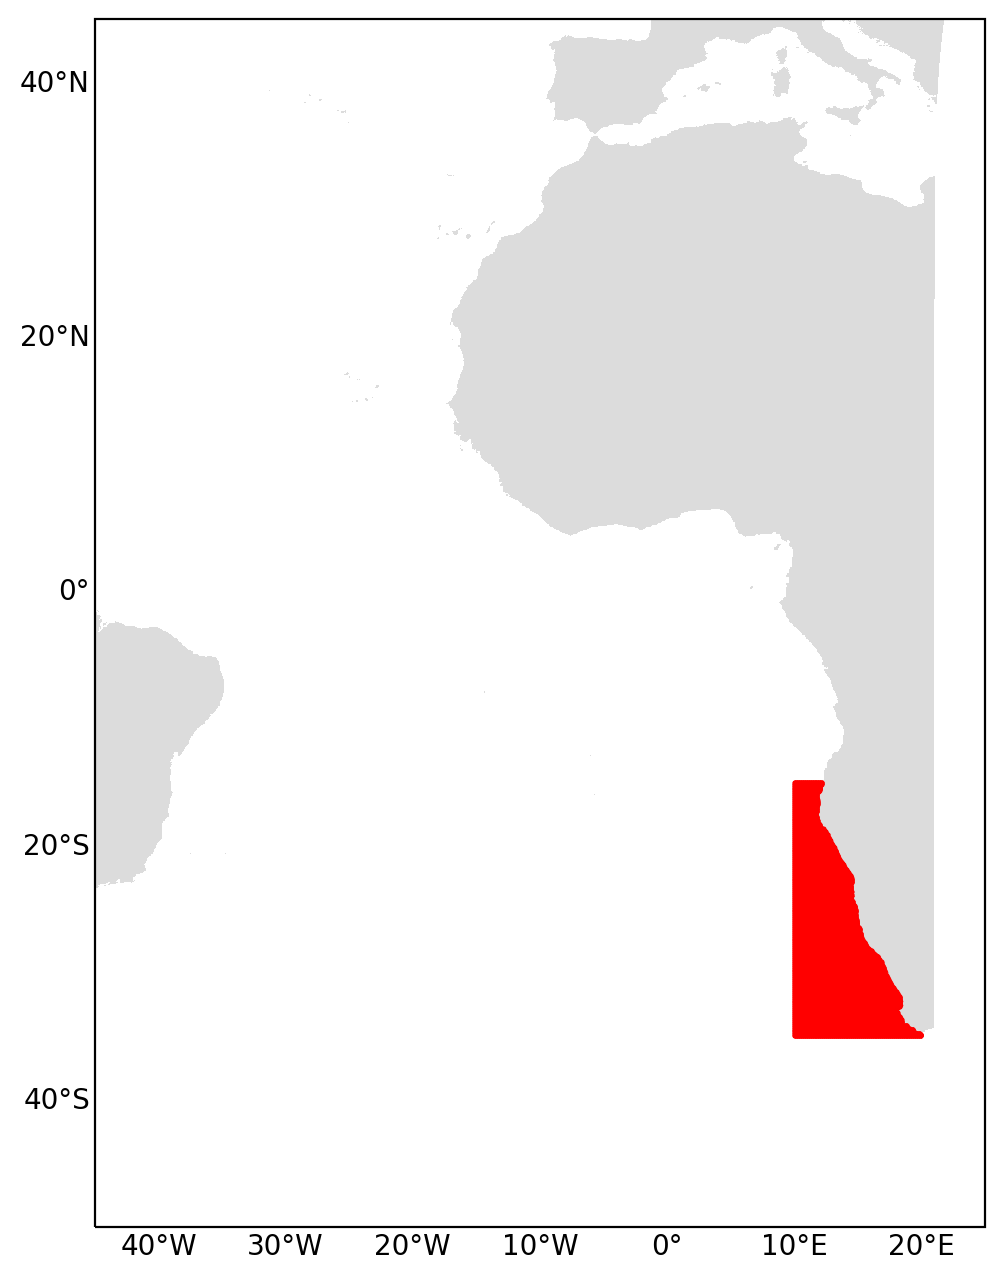

In [13]:

custom_size=10
fig = plt.figure(figsize=(12,8), dpi=200)
ax = plt.axes(projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True)
gl.xlines = False
gl.ylines = False
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': custom_size, 'color': 'k'}
gl.ylabel_style = {'size': custom_size, 'color': 'k'}
# ax.add_feature(cfeature.COASTLINE)
colormap = clr.ListedColormap(['gainsboro', 'white'])
ax.pcolormesh(mask_lon[0, :,:], mask_lat[0, :,:], mask_land[0,0, 1:,1:], cmap=colormap)

ax.set_xlim(-45, 25)
ax.set_ylim(-50, 45)
ax.scatter(ocean_lons, ocean_lats, s=0.1, c="red")
plt.show()

Zoom In

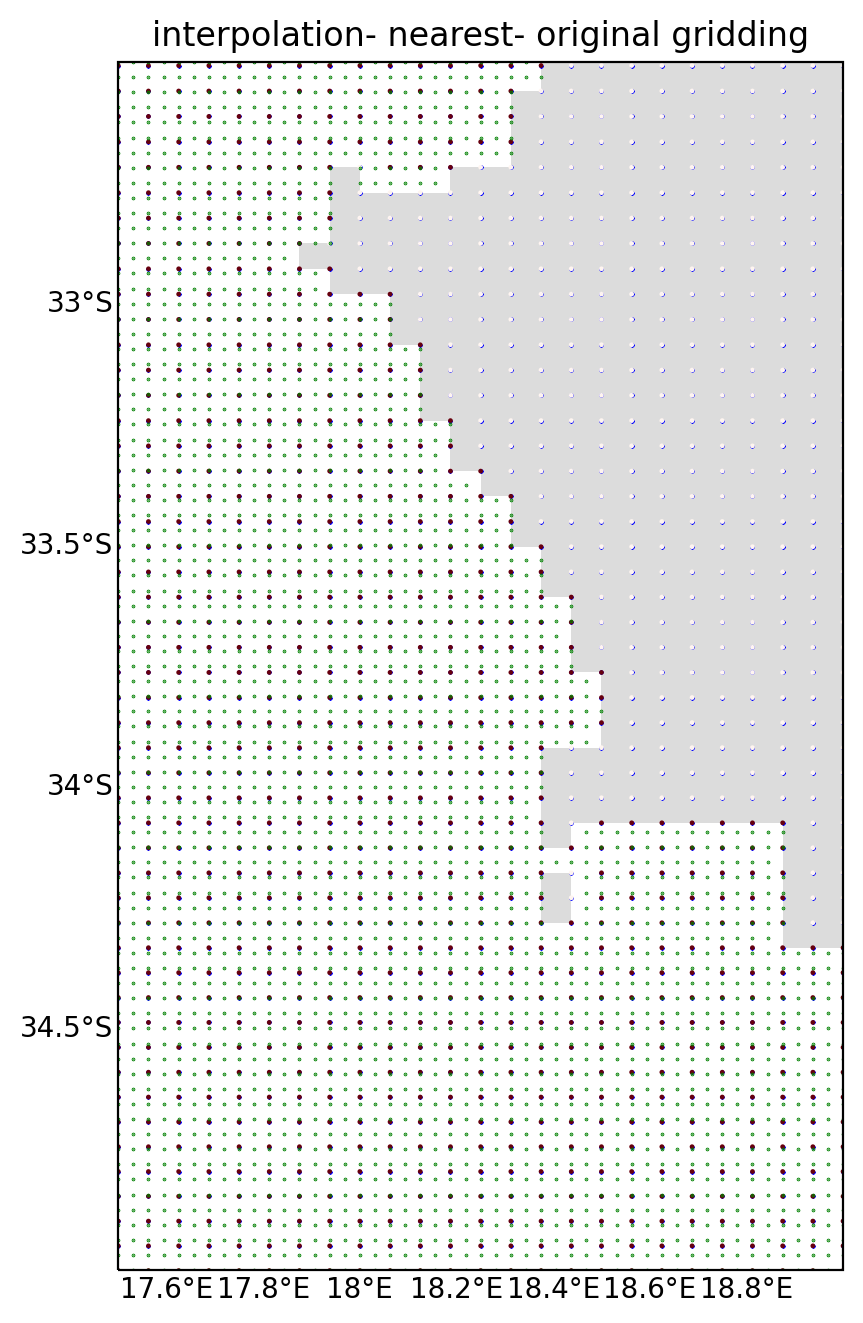

In [10]:
custom_size=10
fig = plt.figure(figsize=(12,8), dpi=200)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title("interpolation- nearest- original gridding")
gl = ax.gridlines(draw_labels=True)
gl.xlines = False
gl.ylines = False
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': custom_size, 'color': 'k'}
gl.ylabel_style = {'size': custom_size, 'color': 'k'}
colormap = clr.ListedColormap(['gainsboro', 'white'])

# Near Amazon river- 4-5 month simulations
ax.pcolormesh(mask_lon[0, 1249:1750, 1499:], mask_lat[0, 1249:1750, 1499:], mask_land[0,0, 1250:1750, 1500:], cmap=colormap)
# ax.pcolormesh(mask_lon[0, :, :], mask_lat[0, :, :], mask_land[0,0, 1:, 1:], cmap=colormap)

ax.scatter(mask_lon[0, 1249:1750, 1499:], mask_lat[0, 1249:1750, 1499:],marker='X',s=0.3, c='blue')
ax.scatter(mask_lon[0, 1249:1750, 1499:], mask_lat[0, 1249:1750, 1499:],c=mask_land[0,0, 1249:1750, 1499:], cmap=plt.cm.Reds, s=0.5)

# ax.scatter(mask_lon[0, :-1, :-1], mask_lat[0, :-1, :-1], c=mask_land[0,0, 1:, 1:], cmap=plt.cm.Reds, s=0.5)

# ax.scatter(mask_lon[0, :, :], mask_lat[0, :, :], c=mask_land[0,0, :, :], cmap=plt.cm.Reds, s=0.5)
# ax.scatter(mask_lon[0, :, :], mask_lat[0, :, :],marker='X',s=0.3, c='red')

# ax.set_xlim(13, 15)
# ax.set_ylim(-25, -22)

ax.set_xlim(17.5, 19)
ax.set_ylim(-35, -32.5)

ax.scatter(ocean_lons, ocean_lats, s=0.1, c="green")
plt.show()

<h3> still some particles remain on land -after filtering- to use a sample simulation to remove those points for the selected resolution!

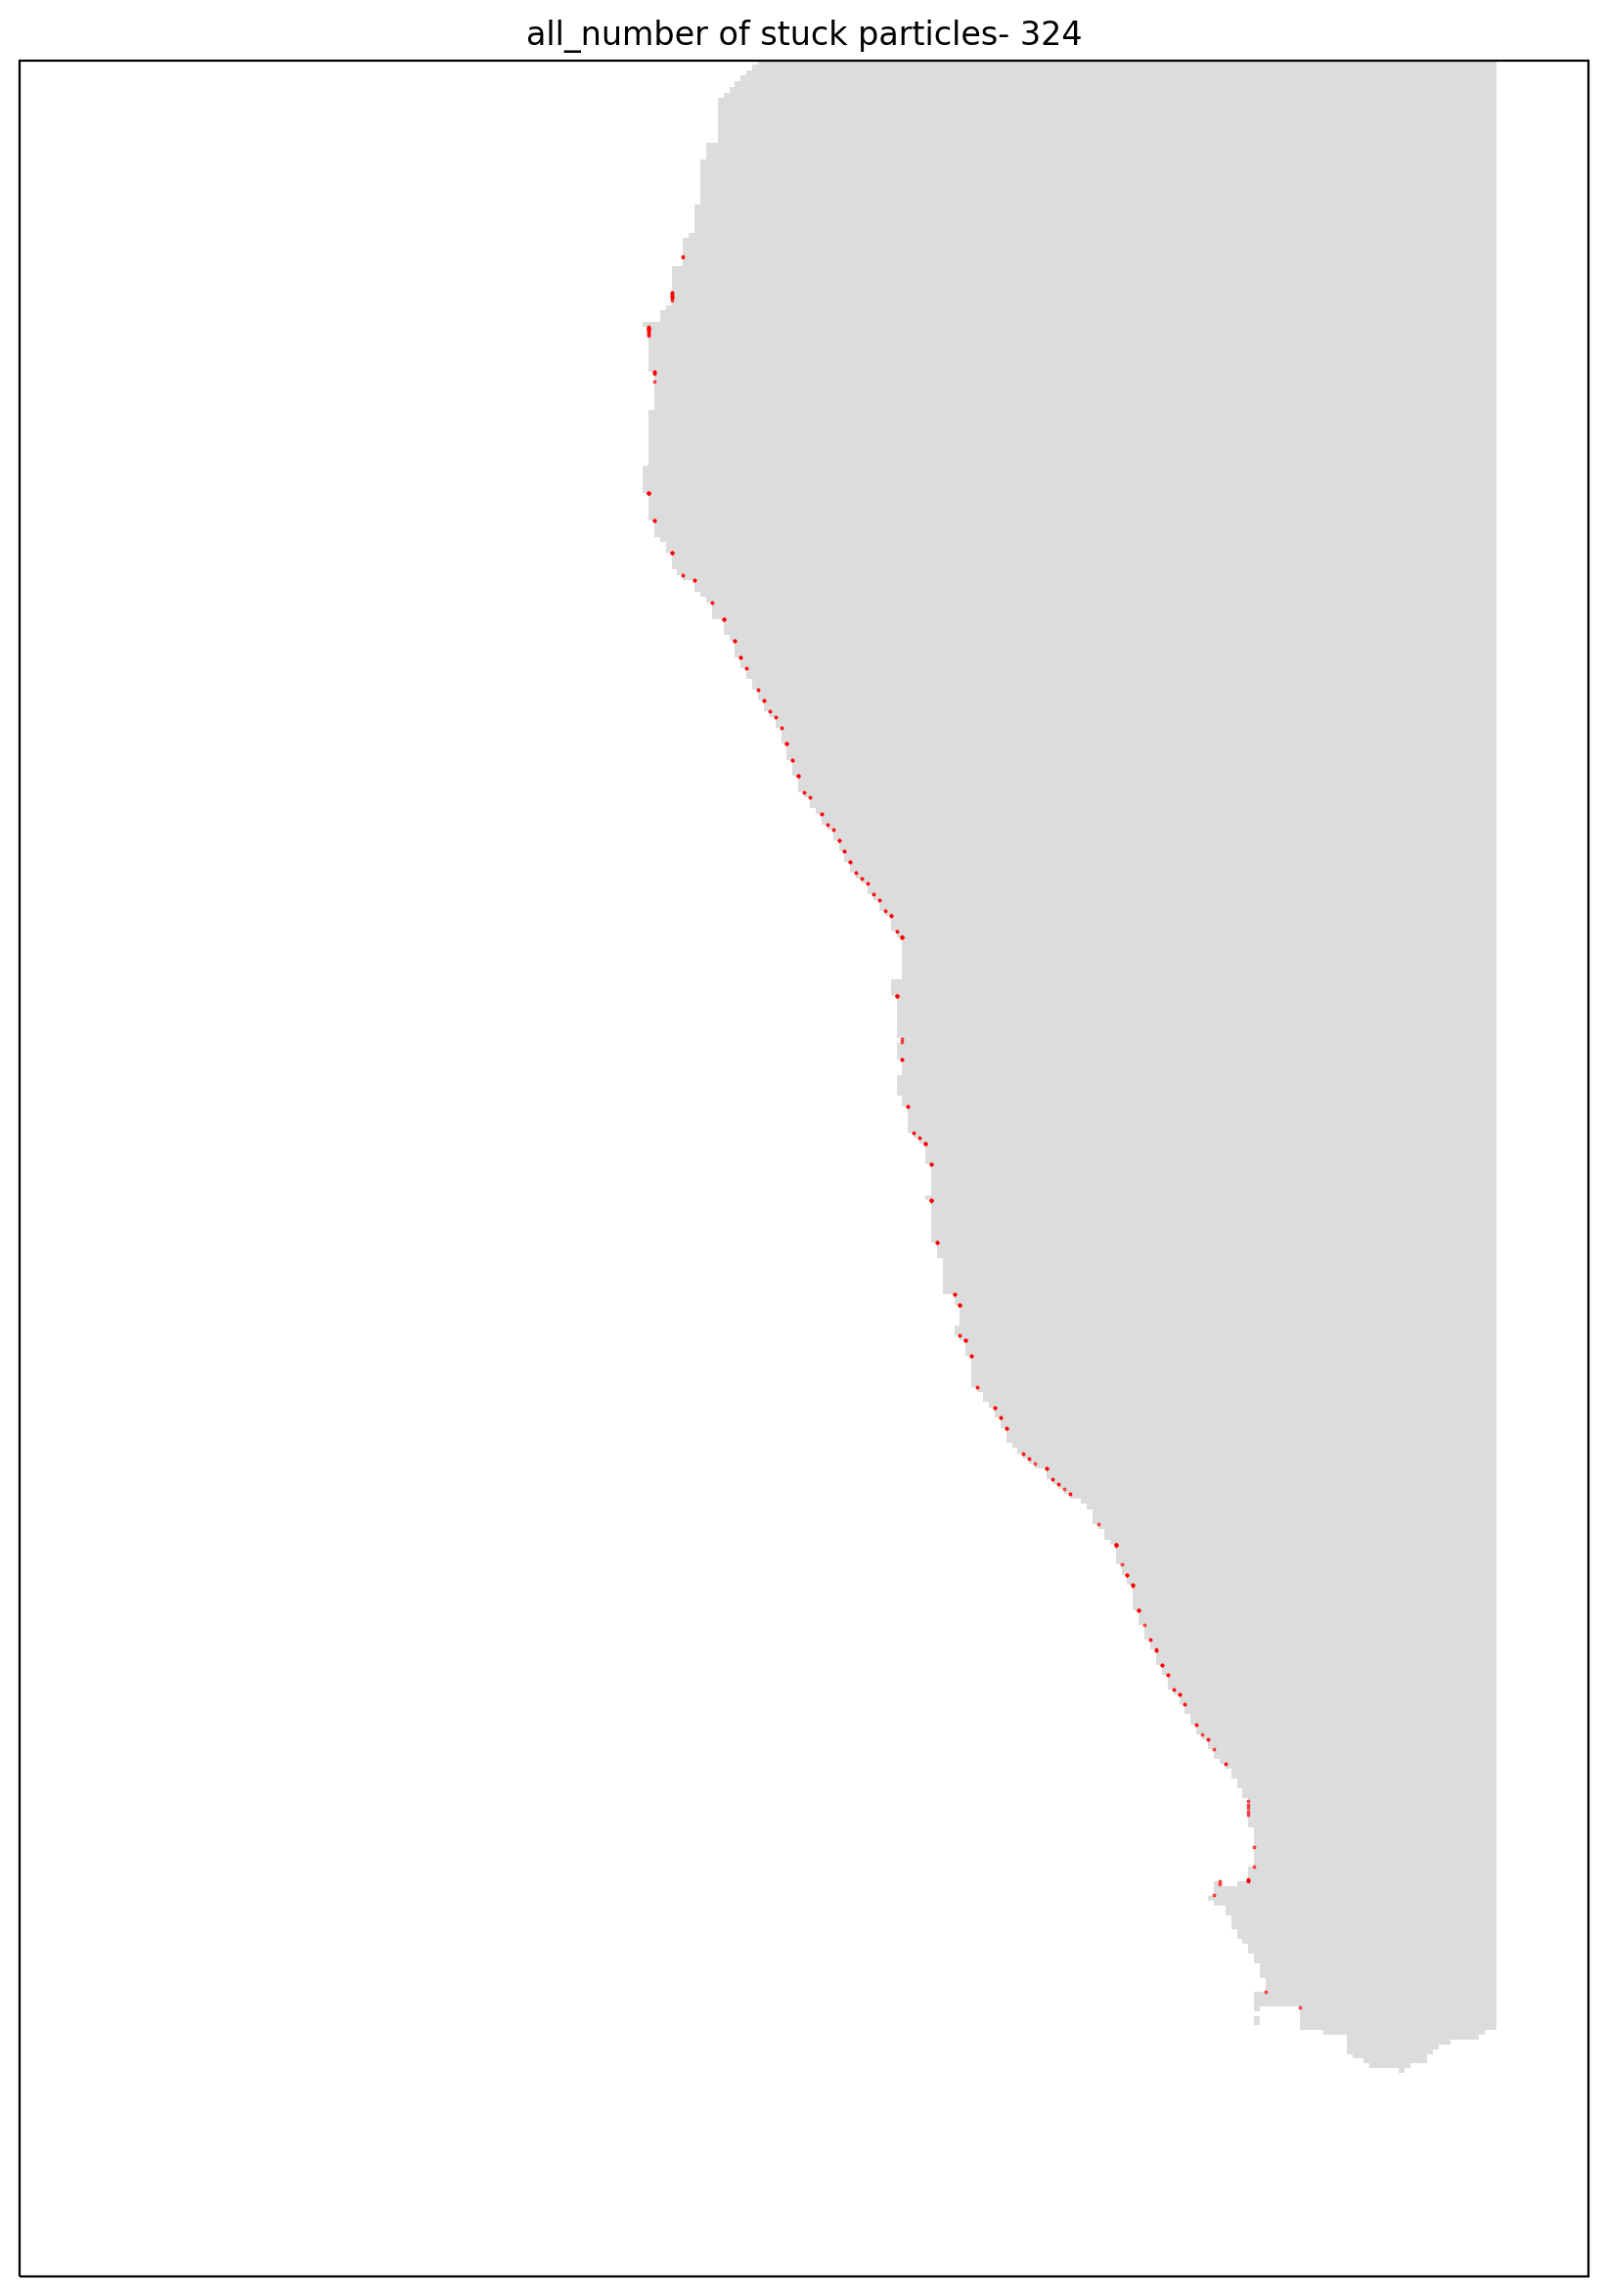

In [65]:
test_ds=xr.open_zarr('/nethome/manra003/analysis/dispersion/simulations/2D/TestBenguelaUpwR_1ov32_641x321res_Jul2017_1z_15days.zarr')

stuck_ids = np.where(np.round(test_ds.lon[:,0],10)==np.round(test_ds.lon[:,-1],10))[0]

fig = plt.figure(figsize=(12,15), dpi=200)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title("all_number of stuck particles- {0}".format(len(stuck_ids)))
colormap = clr.ListedColormap(['gainsboro', 'white'])

# Near Amazon river- 4-5 month simulations
ax.pcolormesh(mask_lon[0, 1249:1750, 1499:], mask_lat[0, 1249:1750, 1499:], mask_land[0,0, 1250:1750, 1500:], cmap=colormap)

ax.set_xlim(17.5, 19)
ax.set_ylim(-35, -32.5)

ax.set_xlim(5, 22)
ax.set_ylim(-37, -13)

ax.scatter(np.take(test_ds.lon[:,-1],stuck_ids), np.take(test_ds.lat[:,-1],stuck_ids), s=0.1, c="red")
plt.show()

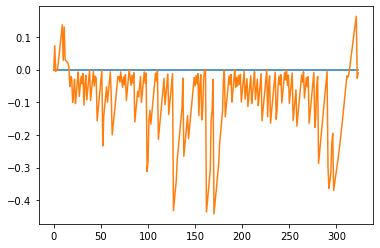

In [50]:
plt.plot(np.take(test_ds.lon[:,0],stuck_ids)-np.take(test_ds.lon[:,-1],stuck_ids))
plt.plot(np.take(test_ds.lat[:,0],stuck_ids)-np.take(test_ds.lat[:,-1],stuck_ids))

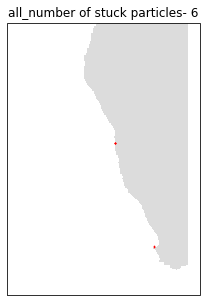

In [52]:
stuck_ids2 = np.where(np.round(test_ds.lat[:,0],10)==np.round(test_ds.lat[:,-1],10))[0]

fig = plt.figure(figsize=(5,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title("all_number of stuck particles- {0}".format(len(stuck_ids2)))
colormap = clr.ListedColormap(['gainsboro', 'white'])

# Near Amazon river- 4-5 month simulations
ax.pcolormesh(mask_lon[0, 1249:1750, 1499:], mask_lat[0, 1249:1750, 1499:], mask_land[0,0, 1250:1750, 1500:], cmap=colormap)

# ax.set_xlim(17.5, 19)
# ax.set_ylim(-35, -32.5)

ax.set_xlim(5, 22)
ax.set_ylim(-37, -13)

ax.scatter(np.take(test_ds.lon[:,-1],stuck_ids2), np.take(test_ds.lat[:,-1],stuck_ids2), s=0.5, c="red")
plt.show()

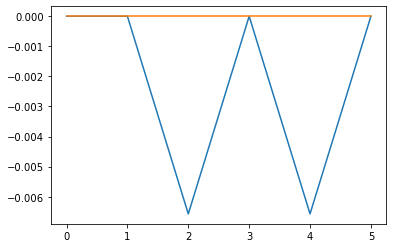

In [53]:
plt.plot(np.take(test_ds.lon[:,0],stuck_ids2)-np.take(test_ds.lon[:,-1],stuck_ids2))
plt.plot(np.take(test_ds.lat[:,0],stuck_ids2)-np.take(test_ds.lat[:,-1],stuck_ids2))

In [28]:
print(np.take(test_ds.lon[:,0],stuck_ids2).values)
np.take(test_ds.lon[:,-1],stuck_ids2).values

[18.      18.      14.53125 14.5625  14.53125 14.5625 ]


array([18.        , 18.        , 14.51168313, 14.5625    , 14.51168902,
       14.5625    ])

In [29]:
print(np.take(test_ds.lat[:,0],stuck_ids2).values)
np.take(test_ds.lat[:,-1],stuck_ids2).values

[-32.75    -32.71875 -23.625   -23.625   -23.59375 -23.59375]


array([-32.75   , -32.71875, -23.625  , -23.625  , -23.59375, -23.59375])

In [36]:
print(np.take(test_ds.lon[:,0],stuck_ids2).values)
print(np.take(test_ds.lon[:,-1],stuck_ids2).values)
print(np.take(test_ds.lat[:,0],stuck_ids2).values)
print(np.take(test_ds.lat[:,-1],stuck_ids2).values)

[18.      18.      14.53125 14.5625  14.53125 14.5625 ]
[18.         18.         14.53782189 14.5625     14.5378205  14.5625    ]
[-32.75    -32.71875 -23.625   -23.625   -23.59375 -23.59375]
[-32.75    -32.71875 -23.625   -23.625   -23.59375 -23.59375]


In [59]:
common = np.intersect1d(stuck_ids2,stuck_ids)
common

array([20426, 20687, 78794, 78941])

<h5>Conclusion:
<p>
Since only a few common points that dont move at all- no additional deletion takes place in the handling.</br>
Using the masked list as is- ocean_lats/lons